## Demo for Proximal_Policy_Optimization

---- 

conda env : [rl_learning](../Book_deep_learning_from_scratch_4/README.md#setup-a-conda-environment)

---
### Reference:

- ***Colab***:
    - https://colab.research.google.com/github/MrSyee/pg-is-all-you-need/blob/master/02.PPO.ipynb#scrollTo=2eKCKKDmffM9


In [1]:
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

In [2]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer


class Actor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        log_std_min: int = -20,
        log_std_max: int = 0,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.hidden = nn.Linear(in_dim, 32)

        self.mu_layer = nn.Linear(32, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

        self.log_std_layer = nn.Linear(32, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))

        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.tanh(self.log_std_layer(x))
        log_std = self.log_std_min + 0.5 * (self.log_std_max - self.log_std_min) * (log_std + 1)
        std = torch.exp(log_std)

        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist


class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden = nn.Linear(in_dim, 64)
        self.out = nn.Linear(64, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        value = self.out(x)

        return value

## Generalized Advantage Estimator(GAE)

*GAE* help to reduce variance while maintaining a proper level of bias. By adjusting parameters $\lambda \in [0, 1]$ and $\gamma \in [0, 1]$. Please see [the paper](https://arxiv.org/pdf/1506.02438) for detailed description.

In [3]:
def compute_gae(
    next_value: list, rewards: list, masks: list, values: list, gamma: float, tau: float
) -> List:
    """Compute gae."""
    values = values + [next_value]
    gae = 0
    returns: Deque[float] = deque()

    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.appendleft(gae + values[step])

    return list(returns)

## PPO Agent
Here is a summary of PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|_plot             | plot the training progresses.                        |


In [4]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    batch_size = states.size(0)
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.choice(batch_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids], values[rand_ids], log_probs[
                rand_ids
            ], returns[rand_ids], advantages[rand_ids]

In [5]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
        seed (int): random seed
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,
        seed: int = 777,
    ):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight
        self.seed = seed

        # device: cpu / gpu
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")
        print(self.device)

        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.005)

        # memory for training
        self.states: List[torch.Tensor] = []
        self.actions: List[torch.Tensor] = []
        self.rewards: List[torch.Tensor] = []
        self.values: List[torch.Tensor] = []
        self.masks: List[torch.Tensor] = []
        self.log_probs: List[torch.Tensor] = []

        # total steps count
        self.total_step = 1

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            value = self.critic(state)
            self.states.append(state)
            self.actions.append(selected_action)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(selected_action))

        return selected_action.cpu().detach().numpy()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        next_state = np.reshape(next_state, (1, -1)).astype(np.float64)
        reward = np.reshape(reward, (1, -1)).astype(np.float64)
        done = np.reshape(done, (1, -1))

        if not self.is_test:
            self.rewards.append(torch.FloatTensor(reward).to(self.device))
            self.masks.append(torch.FloatTensor(1 - done).to(self.device))

        return next_state, reward, done

    def update_model(self, next_state: np.ndarray) -> Tuple[float, float]:
        """Update the model by gradient descent."""
        next_state = torch.FloatTensor(next_state).to(self.device)
        next_value = self.critic(next_state)

        returns = compute_gae(
            next_value,
            self.rewards,
            self.masks,
            self.values,
            self.gamma,
            self.tau,
        )

        states = torch.cat(self.states).view(-1, 3)
        actions = torch.cat(self.actions)
        returns = torch.cat(returns).detach()
        values = torch.cat(self.values).detach()
        log_probs = torch.cat(self.log_probs).detach()
        advantages = returns - values

        actor_losses, critic_losses = [], []

        for state, action, old_value, old_log_prob, return_, adv in ppo_iter(
            epoch=self.epoch,
            mini_batch_size=self.batch_size,
            states=states,
            actions=actions,
            values=values,
            log_probs=log_probs,
            returns=returns,
            advantages=advantages,
        ):
            # calculate ratios
            _, dist = self.actor(state)
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp()

            # actor_loss
            surr_loss = ratio * adv
            clipped_surr_loss = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv

            # entropy
            entropy = dist.entropy().mean()

            actor_loss = (
                -torch.min(surr_loss, clipped_surr_loss).mean() - entropy * self.entropy_weight
            )

            # critic_loss
            value = self.critic(state)
            # clipped_value = old_value + (value - old_value).clamp(-0.5, 0.5)
            critic_loss = (return_ - value).pow(2).mean()

            # train critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())

        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []

        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)

        return actor_loss, critic_loss

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        state = np.expand_dims(state, axis=0)

        actor_losses, critic_losses = [], []
        scores = []
        score = 0

        while self.total_step <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_step += 1
                action = self.select_action(state)
                next_state, reward, done = self.step(action)

                state = next_state
                score += reward[0][0]

                # if episode ends
                if done[0][0]:
                    state, _ = self.env.reset(seed=self.seed)
                    state = np.expand_dims(state, axis=0)
                    scores.append(score)
                    score = 0

                    self._plot(self.total_step, scores, actor_losses, critic_losses)

            actor_loss, critic_loss = self.update_model(next_state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

        # termination
        self.env.close()

    def test(self, video_folder: str):
        """Test the agent."""
        self.is_test = True

        tmp_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = tmp_env

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment


In [6]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [7]:
# environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = ActionNormalizer(env)

In [8]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True


seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

In [9]:
# parameters
num_frames = 60000

agent = PPOAgent(
    env,
    gamma=0.9,
    tau=0.8,
    batch_size=64,
    epsilon=0.2,
    epoch=64,
    rollout_len=2048,
    entropy_weight=0.005,
    seed=seed,
)

mps


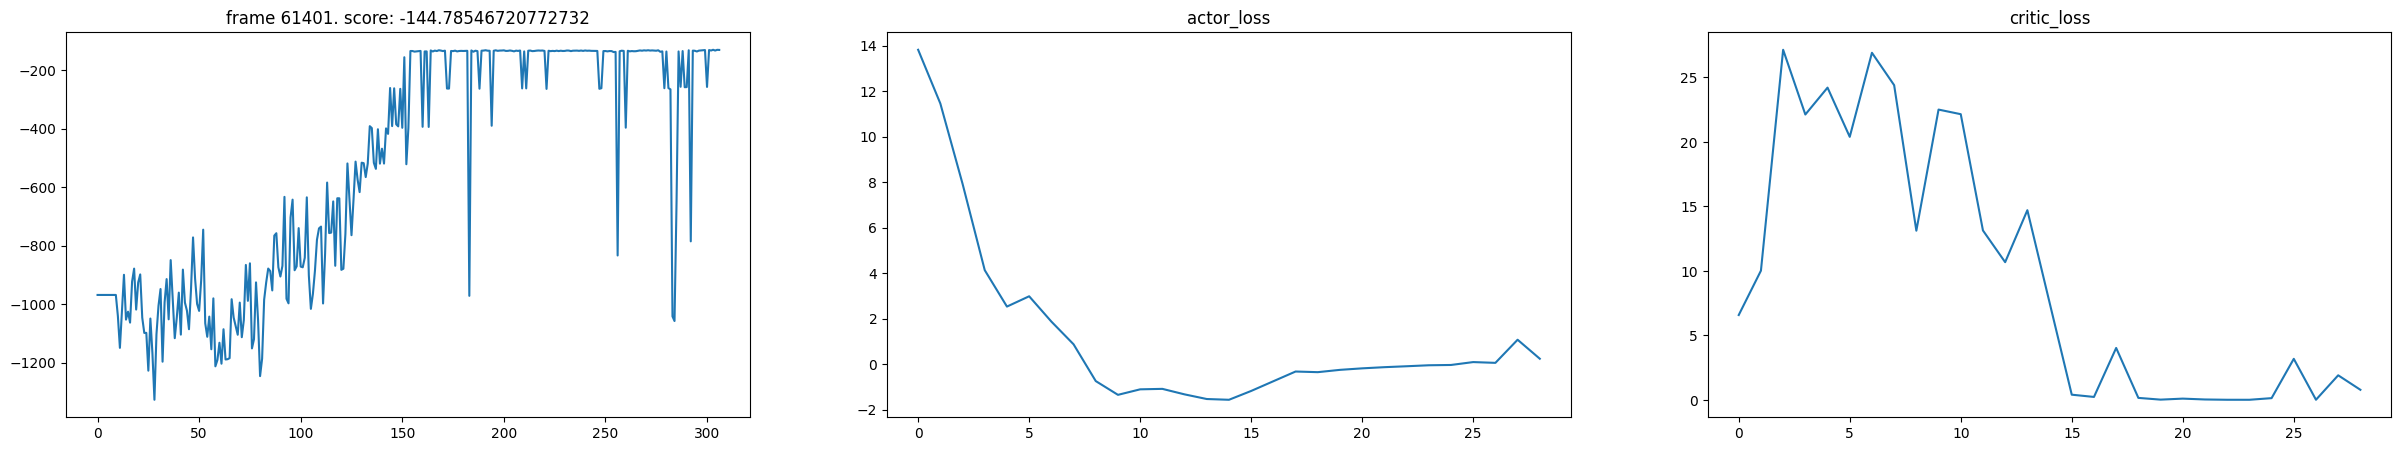

In [10]:
agent.train(num_frames)

In [11]:
# test
video_folder = "./temp/videos/ppo"
agent.test(video_folder=video_folder)

/Users/hyunjae.k/anaconda3/envs/rl_learning/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/hyunjae.k/110_HyunJae_Git/2025_Playgrounds/AI_Robotics_Playgrounds/Experiments/temp/videos/ppo folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/hyunjae.k/anaconda3/envs/rl_learning/lib/python3.10/site-packages/gymnasium/envs/classic_control/pendulum.py:217: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = pygame.math.Vector2(c).rotate_rad(self.state[0] + np.pi / 2)


score:  [[-133.21129971]]


In [12]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(
        HTML(
            data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(
                encoded.decode("ascii")
            )
        )
    )


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: ./temp/videos/ppo/rl-video-episode-0.mp4
